Import the neccessary libraries

In [1]:
import yfinance as yf 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,roc_curve,auc

Data Acquistion and Loading

In [2]:
# Define the ticker for Bank of America and the date range
TICKER = "BAC"
START_DATE = "2015-01-01"
END_DATE = "2024-01-01"

# Download the data using yfinance
# period="max" retrives all available data
print(f"Downloading {TICKER} stock data from {START_DATE} to {END_DATE}.........")
df = yf.download(TICKER,start=START_DATE,end=END_DATE)

C:\Users\Dell\AppData\Local\Temp\ipykernel_6764\246887603.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(TICKER,start=START_DATE,end=END_DATE)
[*********************100%***********************]  1 of 1 completed


In [3]:
df

Price,Close,High,Low,Open,Volume
Ticker,BAC,BAC,BAC,BAC,BAC
Date,,,,,
2015-01-02,14.277459,14.381151,14.101983,14.349245,48951100
2015-01-05,13.862696,14.205674,13.790911,14.189723,105605500
2015-01-06,13.447930,13.910552,13.384121,13.894599,144912400
2015-01-07,13.511733,13.703162,13.455900,13.671257,104603800
2015-01-08,13.790905,13.830786,13.639356,13.687213,73388500
...,...,...,...,...,...
2023-12-22,32.028023,32.257956,31.807669,31.817248,37265900
2023-12-26,32.439991,32.535796,31.970539,32.047186,24845400


In [4]:
df.to_csv("BAC_stock_data.csv",index=False)

In [5]:
print(df.describe())

Price         Close         High          Low         Open        Volume
Ticker          BAC          BAC          BAC          BAC           BAC
count   2264.000000  2264.000000  2264.000000  2264.000000  2.264000e+03
mean      24.252997    24.522219    23.985780    24.257614  6.725666e+07
std        8.199897     8.291336     8.115472     8.205999  3.496952e+07
min        9.010225     9.325099     8.872973     9.252436  1.380540e+07
25%       18.948438    19.192205    18.752122    18.996972  4.438805e+07
50%       24.674417    24.894847    24.382650    24.651481  5.836660e+07
75%       29.442233    29.753309    29.080331    29.383811  7.998865e+07
max       44.836582    45.499425    44.518787    45.317821  3.750887e+08


Feature Engineering

In [6]:
# Calculate Technical Indicators (Features)
# These indicators are used as input to predict the future price movement

# Simple Moving Average (SMA) - Measurs the average price over a period
df["SMA_10"] = df["Close"].rolling(window=10).mean() # 10-day SMA
df["SMA_50"] = df["Close"].rolling(window=50).mean() # 50-day SMA

In [7]:
# Relative Strength Index (RSI) - Measures the magnitude of recent price changes to evaluate 
# overbought or oversold conditions
def calculate_rsi(data,window=14):
    # Calculates the Relative Strength Index (RSI) for closing price
    delta = data["Close"].diff()
    gain = delta.where(delta > 0,0)
    loss = -delta.where(delta < 0,0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi


df["RSI"] = calculate_rsi(df) # 14-day RSI

In [8]:
# Target Variable Creation (Classification Label)
# We want to predict if the price will go "Up" (1) or "Down/Stay" the same (0) tomorrow
# Shift(-1) moves the comparison result up by one day, so today's features predict tomorrow's move.
df["Target"] = (df["Close"].shift(-1) > df["Close"]).astype(int)

In [9]:
# Drop rows with NaN values created by rolling window (SMA,RSI) and last row (Target)
df.dropna(inplace=True)
print(f"Data ready. Total samples after feature engineering: {len(df)}")

Data ready. Total samples after feature engineering: 2215


Data Preparation

In [10]:
# Define features (X) and target (y)
FEATURES = ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_10', 'SMA_50', 'RSI']
X = df[FEATURES]
y = df['Target']

Data Splitting

In [11]:
# Split the data into training and testing sets
# We use a time-series split (shuffling is set to False) to avoid future data leaking into the past
TEST_SIZE = 0.2
N_SPLIT = int(len(df) * (1 - TEST_SIZE))
X_train, X_test = X[:N_SPLIT], X[N_SPLIT:]
y_train, y_test = y[:N_SPLIT], y[N_SPLIT:]

Data Scaling

In [12]:
# Initialize the StandardScaler and fit it only on the training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
# Transform the test data using the scale derived from the training data
X_test_scaled = scaler.transform(X_test)

Pre-Training Visualization

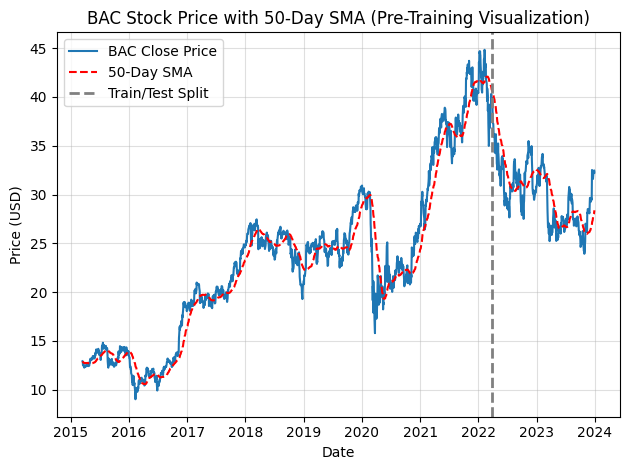

In [13]:
plt.Figure(figsize=(14,6))
# Plot the raw closing price
plt.plot(df.index,df["Close"],label="BAC Close Price",color="#1f77b4")
# Plot the 50-day SMA to show a long term trend
plt.plot(df.index,df["SMA_50"],label="50-Day SMA",color="red",linestyle="--")
# Highlight the classification splits
plt.axvline(X_train.index[-1],color="grey",linestyle="--",linewidth=2,label="Train/Test Split")
plt.title(f"{TICKER} Stock Price with 50-Day SMA (Pre-Training Visualization)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True,alpha=0.4)
plt.tight_layout()
plt.show()

Model Comparison and Training

In [14]:
# Define the dictionary of classifiers to compare
classifiers = {
    "Logistic Regression":LogisticRegression(random_state=42),
    "K-Nearest Neighbours":KNeighborsClassifier(),
    "Random Forest":RandomForestClassifier(random_state=42,n_estimators=100),
    "Support Vector Machine (Linear)":SVC(kernel="linear",probability=True,random_state=42)
}

results = {}

In [15]:
print("----- Model Comparson -----")

# Loop through each classifier, train it and evaluate performance
for name,model in classifiers.items():
    print(f"Training {name}...........")

    # Train the model using the scaled training data
    if name in ["Logistic Regression","K-Nearest Neighbours","Support Vector Machine (Linear)"]:
        model.fit(X_train_scaled,y_train)
        y_pred = model.predict(X_test_scaled)
    else: # Random Forest and Decision Tree don't strictly require scaling
        model.fit(X_train,y_train)
        y_pred = model.predict(X_test)


    # Calculate accuracy
    accuracy = accuracy_score(y_test,y_pred)

    # Store results
    results[name] = accuracy

    # Print the accuracy score
    print(f"{name} Accuracy: {accuracy:.4f}")

# Find the best performing model
best_model_name = max(results,key=results.get)
print(f"Best Performing model based on initial accuracy: {best_model_name}")

----- Model Comparson -----
Training Logistic Regression...........
Logistic Regression Accuracy: 0.4786
Training K-Nearest Neighbours...........
K-Nearest Neighbours Accuracy: 0.4876
Training Random Forest...........
Random Forest Accuracy: 0.4628
Training Support Vector Machine (Linear)...........
Support Vector Machine (Linear) Accuracy: 0.4650
Best Performing model based on initial accuracy: K-Nearest Neighbours


Hyperparameter Tuning

In [20]:
print(f"\n--- Hyperparameter Tuning using RandomizedSearchCV on {best_model_name} ---")

# Define the model and the parameter grid for Randomized Search
rf_model = RandomForestClassifier(random_state=42)
param_dist = {
    'n_estimators': [100, 200, 300, 400], # Number of trees in the forest
    'max_depth': [10, 20, 30, None], # Maximum number of levels in a tree
    'min_samples_split': [2, 5, 10], # Minimum number of data points placed in a node before the node is split
    'min_samples_leaf': [1, 2, 4], # Minimum number of data points allowed in a leaf node
    'criterion': ['gini', 'entropy'] # Function to measure the quality of a split
}

# Initialize RandomizedSearchCV
# n_iter: number of parameter settings that are sampled (a trade-off between time and performance)
# cv: number of cross-validation folds
# verbose: controls the output verbosity
random_search = RandomizedSearchCV(
    estimator=rf_model, 
    param_distributions=param_dist, 
    n_iter=20, # Test 20 random combinations
    cv=3, 
    verbose=0, 
    random_state=42, 
    n_jobs=-1, # Use all available cores for parallel processing
    scoring='accuracy'
)

# Fit the random search model
# Note: We use the unscaled data for tree-based models
random_search.fit(X_train, y_train)

# Get the best estimator and its parameters
best_rf = random_search.best_estimator_
best_params = random_search.best_params_
print(f"Best parameters found: {best_params}")

# Evaluate the tuned model on the test set
y_pred_tuned = best_rf.predict(X_test)
tuned_accuracy = accuracy_score(y_test, y_pred_tuned)

results['Random Forest (Tuned)'] = tuned_accuracy
print(f"Tuned Random Forest Accuracy: {tuned_accuracy:.4f}")

# Final evaluation report for the best (tuned) model
print("\n--- Classification Report for Tuned Random Forest ---")
print(classification_report(y_test, y_pred_tuned))


--- Hyperparameter Tuning using RandomizedSearchCV on K-Nearest Neighbours ---
Best parameters found: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 30, 'criterion': 'entropy'}
Tuned Random Forest Accuracy: 0.4492

--- Classification Report for Tuned Random Forest ---
              precision    recall  f1-score   support

           0       0.48      0.31      0.37       237
           1       0.43      0.61      0.51       206

    accuracy                           0.45       443
   macro avg       0.46      0.46      0.44       443
weighted avg       0.46      0.45      0.44       443



Post-Training Visualization

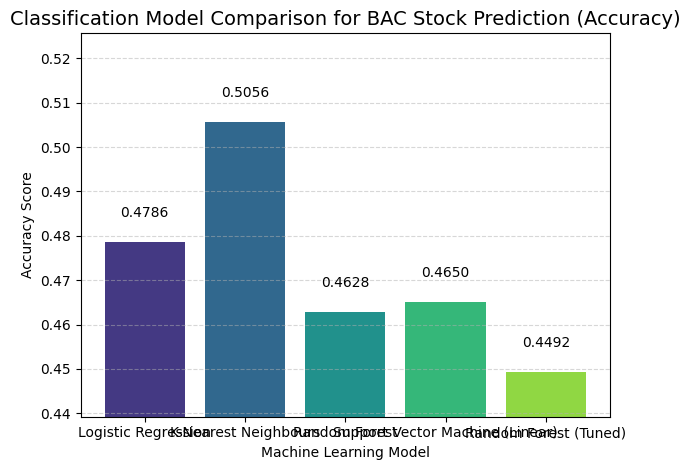

In [21]:
# Prepare data for comparison plot
model_names = list(results.keys())
accuracies = [results[name] for name in model_names]

plt.Figure(figsize=(12,7))
# Create a bar plot comparing the accuracy of all models
bars = plt.bar(model_names,accuracies,color=sns.color_palette("viridis",len(model_names)))

# Add the accuracy value on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, f"{yval:.4f}",ha="center",va="bottom",fontsize=10)
    

plt.ylim(min(accuracies) - 0.01, max(accuracies) + 0.02) # Set y-axis limits
plt.title(f"Classification Model Comparison for {TICKER} Stock Prediction (Accuracy)",fontsize=14)
plt.xlabel("Machine Learning Model")
plt.ylabel("Accuracy Score")
plt.grid(axis="y",linestyle="--",alpha=0.5)
plt.tight_layout()
plt.show()

New Prediction Input Function

In [24]:
def predict_future_price_direction(model,scaler,new_data_point):
    """
    Predicts the target (Up/Down) for a single new data point using the trained model.
    :param model: The trained best model (Random Forest).
    :param scaler: The fitted StandardScaler (only required if the model needs scaled data).
    :param new_data_point: A dictionary or pandas Series with feature values.
    :return: Predicted direction (Up or Down).
    """
    # Create a DataFrame from the new data point
    new_df = pd.DataFrame([new_data_point])

    # Ensure columns match the training features
    if not all (feature in new_df.columns for feature in FEATURES):
        print(f"Error: Missing required features. Must contain: {FEATURES}")
        return "Prediction Failed"
    
    X_new = new_df[FEATURES]

    # Determine if scaling is needed (Random Forest does not need scaling)
    if "Random Forest" not in model_name:
        X_new_processed = scaler.transform(X_new)
    else:
        X_new_processed = X_new

    # Make the prediction
    prediction = model.predict(X_new_processed)[0]

    # Convert prediction (0 or 1) to meaningful text
    direction = "Up (1)" if prediction == 1 else "Down/Stay Same (0)"

    return prediction

In [25]:
# --- Example of a new prediction (using the last row of the test set as mock new data) ---
# NOTE: In a real scenario, you would use actual market data that happened after your test set.
# The Target column is removed because it is the variable we are trying to predict.
mock_new_data = X_test.iloc[0].to_dict() 
# We need to simulate the features for an *unknown* day's close price, 
# so we remove the Target column before making the dictionary.

print("\n--- Example New Prediction ---")
print(f"Features for the mock prediction day: \n{pd.Series(mock_new_data)}")
# Use the best_rf (tuned Random Forest) for prediction
best_model_prediction = predict_future_price_direction(best_rf, scaler, mock_new_data)
print(f"\nPredicted Price Direction for the next day using Tuned Random Forest: {best_model_prediction}")
print(f"Actual direction was: {y_test.iloc[0]}")

# Add a name attribute to the best_rf model for the prediction function
best_rf.name = "Random Forest"



--- Example New Prediction ---
Features for the mock prediction day: 
Open    BAC    3.988233e+01
High    BAC    3.991883e+01
Low     BAC    3.907940e+01
Close   BAC    3.973634e+01
Volume  BAC    3.742860e+07
SMA_10         3.929746e+01
SMA_50         4.066016e+01
RSI            7.655247e+01
dtype: float64
Error: Missing required features. Must contain: ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_10', 'SMA_50', 'RSI']

Predicted Price Direction for the next day using Tuned Random Forest: Prediction Failed
Actual direction was: 0
